## Summary
In this notebook, the paired data from the Streptomyces/Salinispora dataset for the NPClassScore paper. This data originates from MSV000078836, MSV000078839 and MSV000079284 and is described in Crüsemann et al., 2017.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the Streptomyces/Salinispora dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading Streptomyces/Salinispora dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links
- Check MNE coverage over MFs and compare to CANOPUS
- Scoring Spectra to GCF

## Loading Streptomyces/Salinispora dataset

In [280]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../src')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.nplinker import Spectrum
from collections import Counter, defaultdict

In [2]:
# load local crusemann data
npl = NPLinker({'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/'},
                'docker': {'run_canopus': True}})
npl.load_data()

14:44:33 [INFO] config.py:121, Loading from local data in directory /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/
14:44:34 [WARNING] loader.py:50, WARNING: unable to find extra_nodes_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/quantification_table_reformatted/*.csv"
14:44:34 [WARNING] loader.py:50, WARNING: unable to find metadata_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/metadata_table/metadata_table*.txt"
14:44:34 [WARNING] loader.py:50, WARNING: unable to find quantification_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/quantification_table/quantification_table*.csv"
14:44:34 [INFO] loader.py:84, Trying to discover correct bigscape directory under /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/bigscape
14:44:34 [INFO] loader.py:87, Found network files direc

True

In [138]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
spectra_in_dataset = [spec for spec in npl.spectra if 'strains=0' not in str(spec)]
print('Spectra:', len(npl.spectra), # contains Spectrum objects
      '({} spectra actually present in currently selected strains in strain_mappings.csv)'.format(len(spectra_in_dataset)))
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'extra_bigscape_parameters': '', 'run_canopus': True}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
../../src/nplinker/data

/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/
BGCs: 5869
GCFs: 1581
Spectra: 13667 (13381 spectra actually present in currently selected strains in strain_mappings.csv)
Molecular Families: 8346


In [140]:
# Count spectra with chemical class info
spectra_in_dataset_with_class = []
spectra_in_dataset_no_class = []
for spec in spectra_in_dataset:
    spec_can = npl.chem_classes.canopus.spectra_classes.get(str(spec.spectrum_id))
    if not spec_can:
        spec_mne = npl.chem_classes.molnetenhancer.spectra_classes(str(spec.spectrum_id))
        if not spec_mne:
            spectra_in_dataset_no_class.append(spec)
        else:
            spectra_in_dataset_with_class.append(spec)
    else:
        spectra_in_dataset_with_class.append(spec)
print(f"From the {len(spectra_in_dataset)} spectra present in current strains, {len(spectra_in_dataset_with_class)} spectra have class info")

From the 13381 spectra present in current strains, 12236 spectra have class info


## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [4]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

14:48:01 [INFO] methods.py:459, MetcalfScoring.setup (bgcs=5869, gcfs=1581, spectra=13667, molfams=8346, strains=154)
14:48:03 [INFO] methods.py:499, MetcalfScoring.setup completed
Number of results: 1581


In [5]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

14:49:44 [INFO] methods.py:968, Set up NPClassScore scoring
14:49:44 [INFO] methods.py:970, Please choose one of the methods from ['mix', 'main', 'canopus', 'molnetenhancer']
14:49:44 [INFO] methods.py:976, Currently the method 'mix' is selected
14:51:15 [INFO] methods.py:982, Running NPClassScore...
14:51:16 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
14:52:21 [INFO] methods.py:1003, Calculating NPClassScore for 1581 objects to 13667 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
14:55:33 [WARNING] methods.py:1047, 1145 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
14:55:33 [INFO] methods.py:1052, NPClassScore completed in 257.9s
Number of results for Metcalf and NPClassScore scoring: 1575
{<nplinker.scoring.methods.NPClassScoring object at 0x7f79bc730908>, <nplinker.scoring.methods.MetcalfScoring object at 0x7f79ce2160f0>}

In [6]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

14:57:11 [INFO] methods.py:982, Running NPClassScore...
14:57:11 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
14:58:12 [INFO] methods.py:1003, Calculating NPClassScore for 1581 objects to 13667 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
15:01:32 [WARNING] methods.py:1047, 1145 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
15:01:32 [INFO] methods.py:1052, NPClassScore completed in 261.3s
Number of results for Metcalf and NPClassScore scoring: 1581
{<nplinker.scoring.methods.NPClassScoring object at 0x7f790d3513c8>, <nplinker.scoring.methods.MetcalfScoring object at 0x7f79ce2160f0>}


## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [141]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    
    # loop through cutoffs
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            # calculate number of links with npcl filtering
            filtered_links = []
            for link_data in results_0.get_sorted_links(mc, gcf):
                if isinstance(link_data.target, Spectrum):
                    npcl_score = npcl_0.format_data(link_data[npcl_0])
                    if npcl_score:
                        if float(npcl_score) > cs_cut:
                            filtered_links.append(link_data)
                    else:
                        if count_nones:
                            filtered_links.append(link_data)
            num_filtered_links = len(filtered_links)
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)

In [142]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	549.85
0.125	332.96	-0.39
0.25	177.00	-0.68
0.375	149.46	-0.73
0.5	115.89	-0.79
0.625	105.10	-0.81
0.75	64.19	-0.88
0.875	23.13	-0.96


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [144]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        if count_nones:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum)])
        else:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) if link_data[npcl]])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(549.8481973434535, 177.0)

In [145]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.6780929702867792

## Making plots showing the filtered links

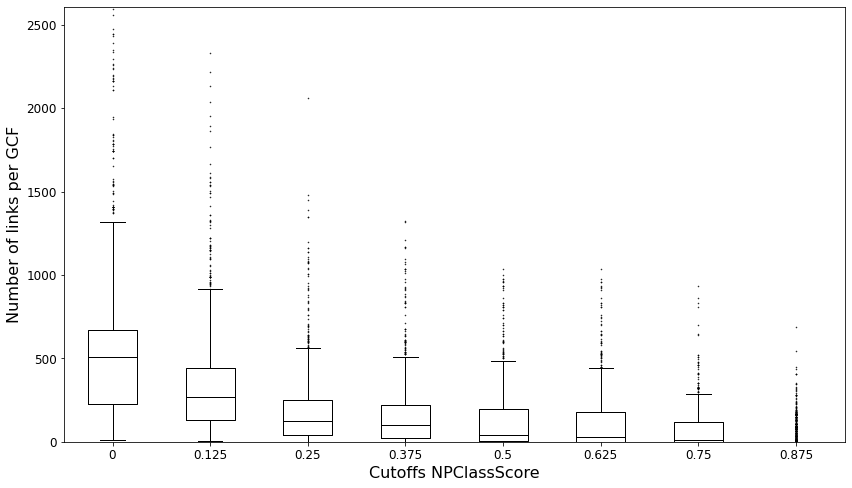

In [146]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, 2607)
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction


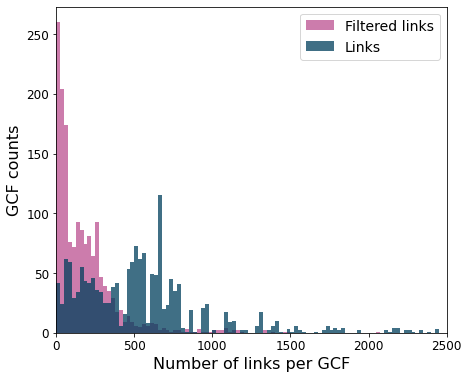

In [147]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, 2500)
bin_size = 25
n_bins = np.arange(0, 2500, bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_mix_can-mne_figure_new.svg"
plt.savefig(figout)

In [289]:
# save xs
xs_out = '/home/louwe015/NPLinker/filtered_data_crusemann.pickle'
pickle.dump(xs, open(xs_out, 'wb'))

## Investigate known links

In [148]:
known_links_dict = {}

### Staurosporine

In [15]:
# Find the right GCF by seeing if this mibig occurs in the knownclusterblast results
key = 'bgc0000827'
result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

26
{GCF(id=378, class=Others, gcf_id=5342, strains=13), GCF(id=587, class=Others, gcf_id=1275, strains=16), GCF(id=534, class=Others, gcf_id=511, strains=54), GCF(id=671, class=Others, gcf_id=2205, strains=1)} 4


In [191]:
name_hit = 'staurosporine'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [89513]  # based on library hits

result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 534][0]
result_gcf, list(result_gcf.bgcs)[:5]

(GCF(id=534, class=Others, gcf_id=511, strains=54),
 [BGC(id=1768, name=NZ_AXVS01000009.region001, strain=Strain(Salinispora arenicola CNR425) [32 aliases], asid=NZ_AXVS01000009, region=1),
  BGC(id=1769, name=NZ_AZVD01000016.region001, strain=Strain(Salinispora arenicola CNT799) [33 aliases], asid=NZ_AZVD01000016, region=1),
  BGC(id=1770, name=NZ_AZWD01000005.region002, strain=Strain(Salinispora arenicola CNX482) [31 aliases], asid=NZ_AZWD01000005, region=2),
  BGC(id=1771, name=NZ_AZWH01000010.region001, strain=Strain(Salinispora arenicola CNH646) [28 aliases], asid=NZ_AZWH01000010, region=1),
  BGC(id=1772, name=NZ_AZWT01000005.region001, strain=Strain(Salinispora arenicola CNX508) [30 aliases], asid=NZ_AZWT01000005, region=1)])

In [192]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 10
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=534, class=Others, gcf_id=511, strains=54), 26 total links, 1 methods used
Rank above cutoff (original rank)
1.(2)	Spectrum(id=3632, spectrum_id=89513, strains=67)	metcalf=8.9996	shared strains=50	MF=243
NPClassScore: (0.780952380952381, 'as_classes', 'cf_superclass', 'indole', 'Organoheterocyclic compounds')
Library match: 7-OH-staurosporine
Precursor_mz: 483.19601
--MATCH--
2.(10)	Spectrum(id=4070, spectrum_id=95003, strains=21)	metcalf=4.7266	shared strains=17	MF=106
NPClassScore: (0.7021276595744681, 'as_classes', 'npc_pathway', 'indole', 'Alkaloids')
Precursor_mz: 497.30899
3.(11)	Spectrum(id=3544, spectrum_id=87806, strains=27)	metcalf=4.6625	shared strains=20	MF=232
NPClassScore: (0.7021276595744681, 'as_classes', 'npc_pathway', 'indole', 'Alkaloids')
Library match: 4-[5-[[4-[5-[acetyl(hydroxy)amino]pentylamino]-4-oxobutanoyl]-hydroxyamino]pentylamino]-4-oxobutanoic acid
Precursor_mz: 481.207
3.(11)	Spectrum(id=4060, spectrum_id=94966, strains=27)	metc

In [193]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

100 16


### Rosamicin

In [194]:
# from Salinispora pacifica CNS237 as listed in PoDP MSV000078836 (mibig entry)
name_hit = 'rosamicin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = []

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_AUGH01000019.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=3761, name=NZ_AUGH01000019.region001, strain=Strain(Salinispora pacifica CNS237) [23 aliases], asid=NZ_AUGH01000019, region=1)]
{GCF(id=944, class=PKSI, gcf_id=1354, strains=2)} 1


In [195]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 944][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=944, class=PKSI, gcf_id=1354, strains=2),
 StrainCollection(n=2) [Salinispora pacifica CNY646,Salinispora pacifica CNS237],
 {BGC(id=3760, name=35578.assembled_unknown.cluster037, strain=Strain(Salinispora pacifica CNY646) [4 aliases], asid=unknown_15, region=-1),
  BGC(id=3761, name=NZ_AUGH01000019.region001, strain=Strain(Salinispora pacifica CNS237) [23 aliases], asid=NZ_AUGH01000019, region=1)})

In [196]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 10
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=944, class=PKSI, gcf_id=1354, strains=2), 54 total links, 1 methods used
Rank above cutoff (original rank)
1.(8)	Spectrum(id=2023, spectrum_id=57072, strains=1)	metcalf=8.7178	shared strains=1	MF=2444
NPClassScore: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: Rhodojaponin II
Precursor_mz: 435.272
1.(8)	Spectrum(id=5072, spectrum_id=111712, strains=1)	metcalf=8.7178	shared strains=1	MF=-1
NPClassScore: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: (2-chloro-4,5-difluorophenyl)-N-[2-(2-methylindol-3-yl)ethyl]carboxamide
Precursor_mz: 524.35797
1.(8)	Spectrum(id=6319, spectrum_id=130529, strains=1)	metcalf=8.7178	shared strains=1	MF=2434
NPClassScore: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: 21-hydroxyrosamicin 
Precursor_mz: 568.38397
--MATCH--
1.(8)	Spectrum(id=7074, spectrum_id=141312, strains=1)	metcal

In [197]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

275 38


### Desferrioxamine

In [198]:
# from S. coelicolor (AL645882.2) as listed in PoDP MSV000078839
# matching to MF 25 https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=cluster_info_sliced&componentindex=25&show=true&task=9360fa514804487a9d39b7e7d7e6d514#%7B%7D
# based on masses that matches well with MF 102, including cluster 66386 (34412 in original)
spectrum_hits = [66386]
name_hit = "desferrioxamine"
known_links_dict[name_hit] = {'hits': [], 'counts': None}

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_003888.3.region009"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=3275, name=NC_003888.3.region009, strain=Strain(Streptomyces coelicolor) [12 aliases], asid=NC_003888.3, region=9)]
{GCF(id=871, class=Others, gcf_id=3830, strains=10)} 1


In [199]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 871][0]
result_gcf, list(result_gcf.bgcs)[:5]

(GCF(id=871, class=Others, gcf_id=3830, strains=10),
 [BGC(id=3272, name=KB898230.1.region001, strain=Strain(Streptomyces sp. CNY228) [32 aliases], asid=KB898230.1, region=1),
  BGC(id=3273, name=KB898273.1.region002, strain=Strain(Streptomyces sp. CNT302) [42 aliases], asid=KB898273.1, region=2),
  BGC(id=3274, name=KE354211.1.region001, strain=Strain(Streptomyces afghanensis) [60 aliases], asid=KE354211.1, region=1),
  BGC(id=3275, name=NC_003888.3.region009, strain=Strain(Streptomyces coelicolor) [12 aliases], asid=NC_003888.3, region=9),
  BGC(id=3266, name=AZUS01000010.1.region001, strain=Strain(Streptomyces sp. CNH189) [52 aliases], asid=AZUS01000010.1, region=1)])

In [200]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 10
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=871, class=Others, gcf_id=3830, strains=10), 1736 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=2339, spectrum_id=66386, strains=8)	metcalf=9.5186	shared strains=7	MF=102
NPClassScore: (0.36363636363636365, 'as_classes', 'npc_class', 'siderophore', 'N-acyl amines')
Library match: NCGC00380283-01!4-[5-[[4-[5-[acetyl(hydroxy)amino]pentylamino]-4-oxobutanoyl]-hydroxyamino]pentylamino]-4-oxobutanoic acid
Precursor_mz: 443.25
--MATCH--
2.(2)	Spectrum(id=3645, spectrum_id=89608, strains=6)	metcalf=9.4509	shared strains=6	MF=2220
NPClassScore: (0.5555555555555556, 'as_classes', 'cf_superclass', 'siderophore', 'Organic acids and derivatives')
Library match: Massbank:AU246701 Tri(butoxyethyl)phosphate|tris(2-butoxyethyl) phosphate
Precursor_mz: 483.245
3.(3)	Spectrum(id=7794, spectrum_id=148375, strains=11)	metcalf=9.2213	shared strains=8	MF=-1
NPClassScore: (0.5555555555555556, 'as_classes', 'cf_superclass', 'siderophore', 'Organic a

In [201]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

2967 1480


### Rifamycin

In [203]:
# from Salinispora arenicola CNS205 as listed in PoDP MSV000078836 (mibig entry) corresponds to NC_009953.1.region007 (knownclusterblast)
# MF 352
name_hit = 'rifamycin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = []

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_009953.1.region007"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=653, name=NC_009953.1.region007, strain=Strain(Salinispora arenicola CNS205) [10 aliases], asid=NC_009953.1, region=7)]
{GCF(id=330, class=PKS-NRP_Hybrids, gcf_id=4267, strains=6), GCF(id=307, class=PKS-NRP_Hybrids, gcf_id=3875, strains=2)} 2


In [204]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 330][0]
result_gcf, list(result_gcf.bgcs)[:2]

(GCF(id=330, class=PKS-NRP_Hybrids, gcf_id=4267, strains=6),
 [BGC(id=653, name=NC_009953.1.region007, strain=Strain(Salinispora arenicola CNS205) [10 aliases], asid=NC_009953.1, region=7),
  BGC(id=654, name=NZ_KB913036.1.region026, strain=Strain(Salinispora arenicola CNS991) [8 aliases], asid=NZ_KB913036.1, region=26)])

In [205]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 1000
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=330, class=PKS-NRP_Hybrids, gcf_id=4267, strains=6), 542 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=1064, spectrum_id=34993, strains=2)	metcalf=7.0468	shared strains=2	MF=261
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Library match: Spectral Match to Tris(2-butoxyethyl) phosphate from NIST14
Precursor_mz: 421.23199
1.(1)	Spectrum(id=1964, spectrum_id=56339, strains=2)	metcalf=7.0468	shared strains=2	MF=-1
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Library match: Massbank:AU150401 Amitriptyline|N,N-dimethyl-3-(2-tricyclo[9.4.0.03,8]pentadeca-1(15),3,5,7,11,13-hexaenylidene)propan-1-amine
Precursor_mz: 434.23099
1.(1)	Spectrum(id=1969, spectrum_id=56380, strains=2)	metcalf=7.0468	shared strains=2	MF=-1
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', '

NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 874.02899
20.(31)	Spectrum(id=12651, spectrum_id=226197, strains=1)	metcalf=4.9666	shared strains=1	MF=-1
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 874.09601
20.(31)	Spectrum(id=12685, spectrum_id=228530, strains=1)	metcalf=4.9666	shared strains=1	MF=-1
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 881.10303
20.(31)	Spectrum(id=12692, spectrum_id=228636, strains=1)	metcalf=4.9666	shared strains=1	MF=-1
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 881.82397
20.(31)	Spectrum(id=12723, spectrum_id=229390, strains=1)	metcalf=4.9666	shared strains=1	MF=-1
NPClassScore: (0.4146341463414634, '

Precursor_mz: 497.22101
164.(275)	Spectrum(id=4197, spectrum_id=96179, strains=6)	metcalf=3.7888	shared strains=2	MF=49
NPClassScore: (0.2743362831858407, 'as_classes', 'cf_superclass', 'NRPS-like', 'Organoheterocyclic compounds')
Precursor_mz: 498.901
164.(275)	Spectrum(id=4216, spectrum_id=96666, strains=6)	metcalf=3.7888	shared strains=2	MF=49
NPClassScore: (0.2743362831858407, 'as_classes', 'cf_superclass', 'NRPS-like', 'Organoheterocyclic compounds')
Library match: N-[2-(3,4-dimethoxyphenyl)ethyl][2-(2-thienylsulfonyl)(3-1,2,3,4-tetrahydroiso quinolyl)]carboxamide
Precursor_mz: 498.901
171.(283)	Spectrum(id=3252, spectrum_id=83442, strains=33)	metcalf=3.7574	shared strains=5	MF=46
NPClassScore: (0.4221218961625282, 'mibig_classes', 'npc_pathway', 'PKS-NRP_Hybrids', 'Amino acids and Peptides')
Library match: Spectral Match to Ile-Pro-Lys from NIST14
Precursor_mz: 471.28201
172.(284)	Spectrum(id=1264, spectrum_id=43223, strains=13)	metcalf=3.7230	shared strains=3	MF=46
NPClassScore:

182.(303)	Spectrum(id=8653, spectrum_id=163141, strains=2)	metcalf=3.3806	shared strains=1	MF=350
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 655.27301
182.(303)	Spectrum(id=8673, spectrum_id=163332, strains=2)	metcalf=3.3806	shared strains=1	MF=-1
NPClassScore: (0.4221218961625282, 'mibig_classes', 'npc_pathway', 'PKS-NRP_Hybrids', 'Amino acids and Peptides')
Library match: Val-DCA
Precursor_mz: 656.28497
182.(303)	Spectrum(id=8676, spectrum_id=163374, strains=2)	metcalf=3.3806	shared strains=1	MF=-1
NPClassScore: (0.4521452145214521, 'mibig_classes', 'npc_superclass', 'PKS-NRP_Hybrids', 'Oligopeptides')
Precursor_mz: 656.30402
182.(303)	Spectrum(id=9116, spectrum_id=167828, strains=2)	metcalf=3.3806	shared strains=1	MF=-1
NPClassScore: (0.5569917743830788, 'as_classes', 'npc_pathway', 'T1PKS', 'Polyketides')
Library match: Solamargine
Precursor_mz: 678.26202
182.(303)	Spectrum(id=9194, spectrum

Library match: Epimedin A1
Precursor_mz: 815.55499
472.(847)	Spectrum(id=12992, spectrum_id=235889, strains=11)	metcalf=2.5327	shared strains=2	MF=243
NPClassScore: (0.4146341463414634, 'mibig_classes', 'cf_superclass', 'PKS-NRP_Hybrids', 'Organic acids and derivatives')
Precursor_mz: 965.39502


In [206]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

856 478


### Lomaivicitin

In [238]:
# from Salinispora tropica CNB440 as listed in PoDP MSV000078836 (mibig entry) corresponds to NC_009380.1.region006 (cblaster)
# MF 643 (corresponds to MF 352 in PoDP MN)
name_hit = 'lomaiviticin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [186635, 178614, 175421, 186632, 175045, 167972, 170438, 167675, 166352]  # based on comparing spectrum characteristics with spectra in MF from PoDP (parent mass, RT)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_009380.1.region006"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=4657, name=NC_009380.1.region006, strain=Strain(Salinispora tropica CNB440) [9 aliases], asid=NC_009380.1, region=6)]
{GCF(id=1230, class=PKSother, gcf_id=4343, strains=15)} 1


In [239]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 1230][0]
result_gcf, list(result_gcf.bgcs)[:2]

(GCF(id=1230, class=PKSother, gcf_id=4343, strains=15),
 [BGC(id=4653, name=35126.assembled_unknown.cluster011, strain=Strain(Salinispora tropica CNY681) [4 aliases], asid=unknown_1, region=-1),
  BGC(id=4654, name=35127.assembled_unknown.cluster028, strain=Strain(Salinispora tropica CNY678) [4 aliases], asid=unknown_5, region=-1)])

In [240]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 100
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=1230, class=PKSother, gcf_id=4343, strains=15), 126 total links, 1 methods used
Rank above cutoff (original rank)
1.(81)	Spectrum(id=4834, spectrum_id=108446, strains=12)	metcalf=4.8824	shared strains=6	MF=137
NPClassScore: (0.4049586776859504, 'as_classes', 'cf_superclass', 'T2PKS', 'Benzenoids')
Library match: (S)-4-((7-acetamido-1,2,3-trimethoxy-9-oxo-5,6,7,9-tetrahydrobenzo[a]heptalen-10-yl)amino)-N-(benzo[d][1,3]dioxol-5-ylmethyl)butanamide
Precursor_mz: 515.42999
2.(93)	Spectrum(id=3696, spectrum_id=89878, strains=4)	metcalf=4.4457	shared strains=3	MF=1843
NPClassScore: (0.4049586776859504, 'as_classes', 'cf_superclass', 'T2PKS', 'Benzenoids')
Library match: Aloe-emodin-8-O-beta-D-glucopyranoside
Precursor_mz: 485.26901
2.(93)	Spectrum(id=12797, spectrum_id=231422, strains=4)	metcalf=4.4457	shared strains=3	MF=-1
NPClassScore: (0.33884297520661155, 'as_classes', 'cf_superclass', 'T2PKS', 'Phenylpropanoids and polyketides')
Library match: (7S,9E,11S,12R,

In [241]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

635 66


### Arenimycin

In [211]:
# from Salinispora arenicola CNB527 as listed in PoDP MSV000078836 (mibig entry) corresponds to NZ_AZXI01000002.region001 (knownclusterblast)

name_hit = 'arenimycin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = []

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_AZXI01000002.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=4690, name=NZ_AZXI01000002.region001, strain=Strain(Salinispora arenicola CNB527) [37 aliases], asid=NZ_AZXI01000002, region=1)]
{GCF(id=1235, class=PKSother, gcf_id=4759, strains=1)} 1


In [212]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 1235][0]
result_gcf, list(result_gcf.bgcs)[:2]

(GCF(id=1235, class=PKSother, gcf_id=4759, strains=1),
 [BGC(id=4690, name=NZ_AZXI01000002.region001, strain=Strain(Salinispora arenicola CNB527) [37 aliases], asid=NZ_AZXI01000002, region=1)])

In [213]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 100
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=1235, class=PKSother, gcf_id=4759, strains=1), 19 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=738, spectrum_id=27315, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.4049586776859504, 'as_classes', 'cf_superclass', 'T2PKS', 'Benzenoids')
Library match: Massbank:EQ305706 Fenhexamid|N-(2,3-dichloro-4-hydroxy-phenyl)-1-methyl-cyclohexanecarboxamide
Precursor_mz: 416.151
1.(1)	Spectrum(id=9478, spectrum_id=175125, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.33884297520661155, 'as_classes', 'cf_superclass', 'T2PKS', 'Phenylpropanoids and polyketides')
Library match: NCGC00381241-01![2-[6-[4-[3,4-dihydroxy-5-(hydroxymethyl)oxolan-2-yl]oxy-2,6-dihydroxy-3-[3-(4-hydroxyphenyl)propanoyl]phenyl]-4,5-dihydroxy-2-methyloxan-3-yl]oxy-3,5-dihydroxy-6-methyloxan-4-yl] (E)-3-(4-hydroxyphenyl)prop-2-enoate
Precursor_mz: 687.16998
1.(1)	Spectrum(id=11884, spectrum_id=211299, strains=1)	metcalf=12.369

In [214]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

103 12


### Enterocin

In [220]:
# cblaster for similarity against BGC0000220 as listed in PoDP - found in Streptomyces sp. CNT318
# KE384240.1.region003 has highest similarity
# MF 969 (MF 49 in PoDP)

name_hit = 'enterocin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [71882, 44705]  # based on comparing spectrum characteristics with spectra in MF from PoDP (parent mass, RT)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "KE384240.1.region003"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=4629, name=KE384240.1.region003, strain=Strain(Streptomyces sp. CNT318) [27 aliases], asid=KE384240.1, region=3)]
{GCF(id=1220, class=PKSother, gcf_id=3784, strains=1)} 1


In [221]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 1220][0]
result_gcf, list(result_gcf.bgcs)[:3]

(GCF(id=1220, class=PKSother, gcf_id=3784, strains=1),
 [BGC(id=4629, name=KE384240.1.region003, strain=Strain(Streptomyces sp. CNT318) [27 aliases], asid=KE384240.1, region=3)])

In [222]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 1000
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=1220, class=PKSother, gcf_id=3784, strains=1), 127 total links, 1 methods used
Rank above cutoff (original rank)
1.(4)	Spectrum(id=1383, spectrum_id=44705, strains=1)	metcalf=12.3693	shared strains=1	MF=969
NPClassScore: (0.4049586776859504, 'as_classes', 'cf_superclass', 'T2PKS', 'Benzenoids')
Library match: NCGC00347754-02!(5-benzoyloxy-4,6-dihydroxy-3-methoxycyclohexen-1-yl)methyl benzoate
Precursor_mz: 429.116
--MATCH--
1.(4)	Spectrum(id=3138, spectrum_id=82700, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.4049586776859504, 'as_classes', 'cf_superclass', 'T2PKS', 'Benzenoids')
Library match: Massbank:RP026601 5?-CHOLANIC ACID-3?-OL-7_12-DIONE|3-Hydroxy-7,12-diketocholanoic acid|(4R)-4-[(3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy-10,13-dimethyl-7,12-dioxo-2,3,4,5,6,8,9,11,14,15,16,17-dodecahydro-1H-cyclopenta[a
Precursor_mz: 467.09201
1.(4)	Spectrum(id=3139, spectrum_id=82701, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore

In [223]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

664 74


### Salinamide

In [234]:
# Looking at knownclusterblast KB899005.1.region001 is the same BGC as the MIBiG entry for salinamide in Streptomyces sp. CNB091
# MF 1932 (MF 25 in PoDP)

name_hit = 'salinamide'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [220718, 220707, 223160, 223158]  # based on comparing spectrum characteristics with PoDP (parent mass, RT)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "KB899005.1.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=609, name=KB899005.1.region001, strain=Strain(Streptomyces sp. CNB091) [63 aliases], asid=KB899005.1, region=1)]
{GCF(id=265, class=PKS-NRP_Hybrids, gcf_id=3718, strains=1)} 1


In [229]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 265][0]
result_gcf, list(result_gcf.bgcs)[:3]

(GCF(id=265, class=PKS-NRP_Hybrids, gcf_id=3718, strains=1),
 [BGC(id=609, name=KB899005.1.region001, strain=Strain(Streptomyces sp. CNB091) [63 aliases], asid=KB899005.1, region=1)])

In [235]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 1000
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=265, class=PKS-NRP_Hybrids, gcf_id=3718, strains=1), 290 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=71, spectrum_id=272, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Library match: NCGC00381153-01![4,5-dihydroxy-3,4-bis(hydroxymethyl)-4a,8,8-trimethyl-5,6,7,8a-tetrahydro-1H-naphthalen-1-yl] octanoate
Precursor_mz: 400.28101
1.(1)	Spectrum(id=1160, spectrum_id=41546, strains=1)	metcalf=12.3693	shared strains=1	MF=3145
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Library match: (E)-10a-(2-(allyloxy)styryl)-10,10-dimethyl-3,4,10,10a-tetrahydropyrimido[1,2-a]indol-2-ol
Precursor_mz: 422.26501
1.(1)	Spectrum(id=1506, spectrum_id=48250, strains=1)	metcalf=12.3693	shared strains=1	MF=1392
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS

In [236]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

621 237


### Cyclomarin

In [250]:
# Looking at knownclusterblast NC_009953.1.region025 is the same BGC as the MIBiG entry for cyclomarin in Salinispora arenicola CNS205
# MF 1886 (MF 489 in PoDP MSV000078836)

name_hit = 'cyclomarin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [239020, 241420, 240820, 239535]  # based on comparing spectrum characteristics with PoDP (parent mass, RT)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_009953.1.region025"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=655, name=NC_009953.1.region025, strain=Strain(Salinispora arenicola CNS205) [10 aliases], asid=NC_009953.1, region=25)]
{GCF(id=308, class=Others, gcf_id=3893, strains=2)} 1


In [251]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 308][0]
result_gcf, list(result_gcf.bgcs)[:3]

(GCF(id=308, class=Others, gcf_id=3893, strains=2),
 [BGC(id=656, name=NZ_AXVS01000052.region001, strain=Strain(Salinispora arenicola CNR425) [32 aliases], asid=NZ_AXVS01000052, region=1),
  BGC(id=655, name=NC_009953.1.region025, strain=Strain(Salinispora arenicola CNS205) [10 aliases], asid=NC_009953.1, region=25)])

In [252]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 1000
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=308, class=Others, gcf_id=3893, strains=2), 366 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=2562, spectrum_id=73756, strains=2)	metcalf=12.3693	shared strains=2	MF=3687
NPClassScore: (1.0, 'as_classes', 'cf_superclass', 'betalactone', 'Organic acids and derivatives')
Library match: NCGC00384721-01!(3aR,6R,7aR)-6-methyl-3-methylidene-6-(4-oxopentyl)-3a,4,7,7a-tetrahydro-1-benzofuran-2,5-dione [IIN-based on: CCMSLIB00000847575]
Precursor_mz: 452.186
1.(1)	Spectrum(id=3163, spectrum_id=82928, strains=2)	metcalf=12.3693	shared strains=2	MF=-1
NPClassScore: (1.0, 'as_classes', 'cf_superclass', 'betalactone', 'Organic acids and derivatives')
Library match: Trp-CDCA
Precursor_mz: 468.18201
3.(4)	Spectrum(id=376, spectrum_id=6602, strains=1)	metcalf=8.7178	shared strains=1	MF=-1
NPClassScore: (1.0, 'as_classes', 'cf_superclass', 'betalactone', 'Organic acids and derivatives')
Library match: Irisflorentin
Precursor_mz: 406.198
3.(4)

Library match: Spectral Match to Ile-Pro-Ile from NIST14
Precursor_mz: 514.289
321.(533)	Spectrum(id=5054, spectrum_id=111524, strains=10)	metcalf=2.5051	shared strains=1	MF=1163
NPClassScore: (0.780952380952381, 'as_classes', 'cf_superclass', 'indole', 'Organoheterocyclic compounds')
Library match: Praeruptorin E
Precursor_mz: 523.24902
321.(533)	Spectrum(id=5417, spectrum_id=115627, strains=10)	metcalf=2.5051	shared strains=1	MF=6002
NPClassScore: (1.0, 'as_classes', 'cf_superclass', 'betalactone', 'Organic acids and derivatives')
Library match: Massbank:RP019801 Dioctylphthalate|Dioctyl phthalate|dioctyl benzene-1,2-dicarboxylate
Precursor_mz: 537.25702
321.(533)	Spectrum(id=9115, spectrum_id=167823, strains=10)	metcalf=2.5051	shared strains=1	MF=-1
NPClassScore: (1.0, 'as_classes', 'cf_superclass', 'betalactone', 'Organic acids and derivatives')
Library match: (3R,5aS,6R,8aS,9R,10S,12R,12aR)-3,6,9-trimethyldecahydro-3H-3,12-epoxy[1,2]dioxepino[4,3-i]isochromen-10-yl 4-((3,4-dihydro

In [253]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

558 335


### Retimycin
We could not find a spectrum for Retimycin in our MN (looking at parent masses in sample 12b.mzXML similar to https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=cluster_info_sliced&componentindex=492&show=true&task=9360fa514804487a9d39b7e7d7e6d514#%7B%7D).

In [275]:
name_hit = 'retimycin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}

In [278]:
# could not find spectrum as described on podp
known_links_dict[name_hit]['not_found'] = 'no spectrum found'

### Actinomycin D

In [270]:
# Looking at cblaster JNLT01000010.1.region001 is the only BGC showing high similarity to actinomycin BGC0000296 as listed
# in PoDP MSV000078839
# MF 5390 (MF 44 in PoDP MSV000078839)

name_hit = 'actinomycin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [150407, 154952]  # based on comparing spectrum characteristics with PoDP (parent mass, RT)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "JNLT01000010.1.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=537, name=JNLT01000010.1.region001, strain=Strain(Streptomyces sp. CNS654) [78 aliases], asid=JNLT01000010.1, region=1)]
{GCF(id=212, class=NRPS, gcf_id=3444, strains=1)} 1


In [266]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 212][0]
result_gcf, list(result_gcf.bgcs)[:3]

(GCF(id=212, class=NRPS, gcf_id=3444, strains=1),
 [BGC(id=537, name=JNLT01000010.1.region001, strain=Strain(Streptomyces sp. CNS654) [78 aliases], asid=JNLT01000010.1, region=1)])

In [271]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 1000
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=212, class=NRPS, gcf_id=3444, strains=1), 394 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=221, spectrum_id=4269, strains=1)	metcalf=12.3693	shared strains=1	MF=6
NPClassScore: (0.2743362831858407, 'as_classes', 'cf_superclass', 'NRPS-like', 'Organoheterocyclic compounds')
Library match: Massbank:AU259101 Imidacloprid-urea|1-[(6-chloropyridin-3-yl)methyl]imidazolidin-2-one
Precursor_mz: 401.28601
1.(1)	Spectrum(id=348, spectrum_id=6380, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.2743362831858407, 'as_classes', 'cf_superclass', 'NRPS-like', 'Organoheterocyclic compounds')
Library match: convolicine
Precursor_mz: 405.18399
1.(1)	Spectrum(id=374, spectrum_id=6563, strains=1)	metcalf=12.3693	shared strains=1	MF=-1
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Library match: (2E)-1-(3,4-dimethoxyphenyl)-3-(2-nitrophenyl)prop-2-en-1-one
Precurso

NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Library match: (2S,3R)-2-(((S)-7-acetamido-1,2,3-trimethoxy-9-oxo-5,6,7,9-tetrahydrobenzo[a]heptalen-10-yl)amino)-N-(3-methoxypropyl)-3-methyl-N-(((1S,9aR)-octahydro-1H-quinolizin-1-yl)methyl)pentanamide
Precursor_mz: 766.53198
272.(594)	Spectrum(id=803, spectrum_id=28379, strains=13)	metcalf=3.2933	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Library match: Massbank:AU247106 Hexa(methoxymethyl)melamine|2-N,2-N,4-N,4-N,6-N,6-N-hexakis(methoxymethyl)-1,3,5-triazine-2,4,6-triamine
Precursor_mz: 419.17899
272.(594)	Spectrum(id=7350, spectrum_id=143472, strains=13)	metcalf=3.2933	shared strains=1	MF=428
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Library match: Cinobufotalin
Precursor_mz: 609.39502
272.(594)	Spectrum(id=8005, spectrum_id=151223, strains=1

In [272]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

756 333


### Summarising known links

In [279]:
for k,v in known_links_dict.items():
    print(k,v)
    print()

staurosporine {'hits': [(1, 2, GCF(id=534, class=Others, gcf_id=511, strains=54), ObjectLink(source=GCF(id=534, class=Others, gcf_id=511, strains=54), target=Spectrum(id=3632, spectrum_id=89513, strains=67), #methods=1)), (3, 11, GCF(id=534, class=Others, gcf_id=511, strains=54), ObjectLink(source=GCF(id=534, class=Others, gcf_id=511, strains=54), target=Spectrum(id=4060, spectrum_id=94966, strains=27), #methods=1))], 'counts': (100, 16)}

rosamicin {'hits': [(1, 8, GCF(id=944, class=PKSI, gcf_id=1354, strains=2), ObjectLink(source=GCF(id=944, class=PKSI, gcf_id=1354, strains=2), target=Spectrum(id=6319, spectrum_id=130529, strains=1), #methods=1)), (1, 8, GCF(id=944, class=PKSI, gcf_id=1354, strains=2), ObjectLink(source=GCF(id=944, class=PKSI, gcf_id=1354, strains=2), target=Spectrum(id=7074, spectrum_id=141312, strains=1), #methods=1))], 'counts': (275, 38)}

desferrioxamine {'hits': [(1, 1, GCF(id=871, class=Others, gcf_id=3830, strains=10), ObjectLink(source=GCF(id=871, class=Othe

In [286]:
pickle_known_links_dict = {}
for k,v in known_links_dict.items():
    new_known_links = {}
    hit_list = v['hits']
    new_hit_list = [([hit[0], hit[1]]) for hit in hit_list]
    new_known_links['hits'] = new_hit_list
    new_known_links['counts'] = v['counts']
    if v.get('not_found'):
        new_known_links['not_found'] = v['not_found']
    pickle_known_links_dict[k] = new_known_links
pickle_known_links_dict

{'staurosporine': {'hits': [[1, 2], [3, 11]], 'counts': (100, 16)},
 'rosamicin': {'hits': [[1, 8], [1, 8]], 'counts': (275, 38)},
 'desferrioxamine': {'hits': [[1, 1],
   [4, 4],
   [5, 5],
   [5, 5],
   [9, 9],
   [10, 10]],
  'counts': (2967, 1480)},
 'rifamycin': {'hits': [[152, 257]], 'counts': (856, 478)},
 'lomaiviticin': {'hits': [[30, 381]], 'counts': (635, 66)},
 'arenimycin': {'hits': [[1, 1]], 'counts': (103, 12)},
 'enterocin': {'hits': [[1, 4]], 'counts': (664, 74)},
 'salinamide': {'hits': [[1, 1], [41, 85]], 'counts': (621, 237)},
 'cyclomarin': {'hits': [[3, 4], [3, 4], [3, 4], [3, 4]],
  'counts': (558, 335)},
 'retimycin': {'hits': [], 'counts': None, 'not_found': 'no spectrum found'},
 'actinomycin': {'hits': [[1, 1], [1, 1]], 'counts': (756, 333)}}

In [288]:
known_links_out = '/home/louwe015/NPLinker/known_links_dict_crusemann.pickle'
pickle.dump(pickle_known_links_dict, open(known_links_out, 'wb'))

## Check MNE coverage over MFs and compare to CANOPUS

In [80]:
mne_component_dict = npl.chem_classes.molnetenhancer.molfam_classes
mne_cluster2component = npl.chem_classes.molnetenhancer.spectra2molfam
columns = npl.chem_classes.molnetenhancer.spectra_classes_names

In [88]:
column_counters = [Counter() for col in columns]

for values in mne_component_dict.values():
    for i, tup in enumerate(values):
        if tup:
            column_counters[i].update([tup[0]])
        else:
            column_counters[i].update(str(tup))

In [89]:
columns[1], column_counters[1], len(mne_component_dict)

('cf_superclass',
 Counter({'Benzenoids': 199,
          'Phenylpropanoids and polyketides': 1001,
          'Organoheterocyclic compounds': 484,
          'Alkaloids and derivatives': 110,
          'Lipids and lipid-like molecules': 1512,
          'Organic acids and derivatives': 1605,
          'Organic oxygen compounds': 169,
          'Organic nitrogen compounds': 76,
          'Nucleosides, nucleotides, and analogues': 17,
          'Lignans, neolignans and related compounds': 56,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 16,
          'Organic Polymers': 35,
          'Organohalogen compounds': 8}),
 5289)

cf_superclass 
 [(0.1, 5), (0.2, 51), (0.3, 191), (0.4, 192), (0.5, 412), (0.6, 114), (0.7, 84), (0.8, 75), (0.9, 19), (1.0, 4146)] 
 5289


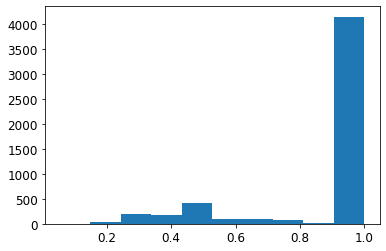

In [91]:
# now for scores rounded on 1 decimal
column_counters = [Counter() for col in columns]
column_vals = [[] for col in columns]
x = 1  # superclass

for values in mne_component_dict.values():
    for i, tup in enumerate(values):
        if tup:
            column_vals[i].append(tup[1])
            column_counters[i].update([round(tup[1],1)])
print(columns[x],'\n', sorted(column_counters[x].items()), '\n', len(mne_component_dict))
plt.hist(column_vals[x], bins=10)
plt.show()

In [97]:
# nodes with a superclass
node_superclass_counts = Counter()
for node, comp in mne_cluster2component.items():
    if comp in mne_component_dict:
        superclass = mne_component_dict[comp][1][0]
        node_superclass_counts.update([superclass])
columns[1], sorted(node_superclass_counts.most_common()), len(mne_cluster2component)

('cf_superclass',
 [('Alkaloids and derivatives', 173),
  ('Benzenoids', 281),
  ('Hydrocarbon derivatives', 17),
  ('Lignans, neolignans and related compounds', 61),
  ('Lipids and lipid-like molecules', 4597),
  ('Nucleosides, nucleotides, and analogues', 18),
  ('Organic Polymers', 105),
  ('Organic acids and derivatives', 2437),
  ('Organic nitrogen compounds', 79),
  ('Organic oxygen compounds', 231),
  ('Organohalogen compounds', 16),
  ('Organoheterocyclic compounds', 1013),
  ('Organosulfur compounds', 1),
  ('Phenylpropanoids and polyketides', 1528)],
 13667)

In [98]:
for t1,t2 in sorted(node_superclass_counts.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	173
Benzenoids	281
Hydrocarbon derivatives	17
Lignans, neolignans and related compounds	61
Lipids and lipid-like molecules	4597
Nucleosides, nucleotides, and analogues	18
Organic Polymers	105
Organic acids and derivatives	2437
Organic nitrogen compounds	79
Organic oxygen compounds	231
Organohalogen compounds	16
Organoheterocyclic compounds	1013
Organosulfur compounds	1
Phenylpropanoids and polyketides	1528


In [100]:
sum(node_superclass_counts.values())

10557

In [102]:
# nodes with a superclass <850 Da to compare to canopus
node_superclass_counts_cut = Counter()
cut = 850
for node, comp in mne_cluster2component.items():
    spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
    if spec.parent_mz < cut:
        if comp in mne_component_dict:
            superclass = mne_component_dict[comp][1][0]
            node_superclass_counts_cut.update([superclass])
columns[1], node_superclass_counts_cut, sum(node_superclass_counts_cut.values())

('cf_superclass',
 Counter({'Benzenoids': 263,
          'Phenylpropanoids and polyketides': 1373,
          'Organoheterocyclic compounds': 981,
          'Alkaloids and derivatives': 150,
          'Lipids and lipid-like molecules': 3603,
          'Organic acids and derivatives': 1865,
          'Organic oxygen compounds': 209,
          'Organic nitrogen compounds': 78,
          'Nucleosides, nucleotides, and analogues': 18,
          'Lignans, neolignans and related compounds': 60,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 14,
          'Organohalogen compounds': 16,
          'Organic Polymers': 10}),
 8641)

In [103]:
for t1,t2 in sorted(node_superclass_counts_cut.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	150
Benzenoids	263
Hydrocarbon derivatives	14
Lignans, neolignans and related compounds	60
Lipids and lipid-like molecules	3603
Nucleosides, nucleotides, and analogues	18
Organic Polymers	10
Organic acids and derivatives	1865
Organic nitrogen compounds	78
Organic oxygen compounds	209
Organohalogen compounds	16
Organoheterocyclic compounds	981
Organosulfur compounds	1
Phenylpropanoids and polyketides	1373


In [105]:
# nodes with a superclass that have canopus prediction
node_superclass_counts_also_canopus = Counter()
for node, comp in mne_cluster2component.items():
    spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
    if node in npl.chem_classes.canopus.spectra_classes:
        if comp in mne_component_dict:
            superclass = mne_component_dict[comp][1][0]
            node_superclass_counts_also_canopus.update([superclass])
columns[1], node_superclass_counts_also_canopus, sum(node_superclass_counts_also_canopus.values())

('cf_superclass',
 Counter({'Benzenoids': 203,
          'Phenylpropanoids and polyketides': 951,
          'Organoheterocyclic compounds': 773,
          'Alkaloids and derivatives': 119,
          'Lipids and lipid-like molecules': 2686,
          'Organic acids and derivatives': 1553,
          'Organic oxygen compounds': 165,
          'Organic nitrogen compounds': 72,
          'Nucleosides, nucleotides, and analogues': 16,
          'Lignans, neolignans and related compounds': 33,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 8,
          'Organohalogen compounds': 16,
          'Organic Polymers': 10}),
 6606)

In [106]:
for t1,t2 in sorted(node_superclass_counts_also_canopus.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	119
Benzenoids	203
Hydrocarbon derivatives	8
Lignans, neolignans and related compounds	33
Lipids and lipid-like molecules	2686
Nucleosides, nucleotides, and analogues	16
Organic Polymers	10
Organic acids and derivatives	1553
Organic nitrogen compounds	72
Organic oxygen compounds	165
Organohalogen compounds	16
Organoheterocyclic compounds	773
Organosulfur compounds	1
Phenylpropanoids and polyketides	951


In [109]:
# compare to CANOPUS
node_canopus_superclass_count = Counter()
for spectrum in npl.spectra:
    classes = npl.chem_classes.canopus.spectra_classes.get(str(spectrum.spectrum_id))
    if classes:
        node_canopus_superclass_count.update([classes[1][0][0]])
npl.chem_classes.canopus.spectra_classes_names[1], sorted(node_canopus_superclass_count.most_common()), sum(node_canopus_superclass_count.values())

('cf_superclass',
 [('Alkaloids and derivatives', 9),
  ('Benzenoids', 522),
  ('Hydrocarbon derivatives', 13),
  ('Hydrocarbons', 1),
  ('Lignans, neolignans and related compounds', 3),
  ('Lipids and lipid-like molecules', 1647),
  ('Nucleosides, nucleotides, and analogues', 136),
  ('Organic 1,3-dipolar compounds', 30),
  ('Organic Polymers', 2),
  ('Organic acids and derivatives', 4057),
  ('Organic nitrogen compounds', 280),
  ('Organic oxygen compounds', 882),
  ('Organoheterocyclic compounds', 731),
  ('Organophosphorus compounds', 2),
  ('Organosulfur compounds', 29),
  ('Phenylpropanoids and polyketides', 202)],
 8546)

In [110]:
for t1,t2 in sorted(node_canopus_superclass_count.most_common()):
    print(f"{t1}\t{t2}")

Alkaloids and derivatives	9
Benzenoids	522
Hydrocarbon derivatives	13
Hydrocarbons	1
Lignans, neolignans and related compounds	3
Lipids and lipid-like molecules	1647
Nucleosides, nucleotides, and analogues	136
Organic 1,3-dipolar compounds	30
Organic Polymers	2
Organic acids and derivatives	4057
Organic nitrogen compounds	280
Organic oxygen compounds	882
Organoheterocyclic compounds	731
Organophosphorus compounds	2
Organosulfur compounds	29
Phenylpropanoids and polyketides	202


In [113]:
# canopus predictions that also have MNE predictions
canopus_also_mne_superclass = Counter()
for node, comp in mne_cluster2component.items():
    if comp in mne_component_dict:
        spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
        if mne_component_dict[comp][1][0] and not mne_component_dict[comp][1][0] == 'no matches':
            classes = npl.chem_classes.canopus.spectra_classes.get(node)
            if classes:
                superclass = classes[1][0][0]
                canopus_also_mne_superclass.update([superclass])
columns[1], canopus_also_mne_superclass, sum(canopus_also_mne_superclass.values())

('cf_superclass',
 Counter({'Benzenoids': 338,
          'Lipids and lipid-like molecules': 1301,
          'Organic nitrogen compounds': 243,
          'Nucleosides, nucleotides, and analogues': 81,
          'Hydrocarbon derivatives': 13,
          'Organic oxygen compounds': 700,
          'Organic acids and derivatives': 3229,
          'Organoheterocyclic compounds': 534,
          'Phenylpropanoids and polyketides': 113,
          'Organosulfur compounds': 24,
          'Alkaloids and derivatives': 7,
          'Organic 1,3-dipolar compounds': 16,
          'Lignans, neolignans and related compounds': 3,
          'Organophosphorus compounds': 2,
          'Hydrocarbons': 1,
          'Organic Polymers': 1}),
 6606)

In [114]:
for t1,t2 in sorted(canopus_also_mne_superclass.most_common()):
    print(f"{t1}\t{t2}")

Alkaloids and derivatives	7
Benzenoids	338
Hydrocarbon derivatives	13
Hydrocarbons	1
Lignans, neolignans and related compounds	3
Lipids and lipid-like molecules	1301
Nucleosides, nucleotides, and analogues	81
Organic 1,3-dipolar compounds	16
Organic Polymers	1
Organic acids and derivatives	3229
Organic nitrogen compounds	243
Organic oxygen compounds	700
Organoheterocyclic compounds	534
Organophosphorus compounds	2
Organosulfur compounds	24
Phenylpropanoids and polyketides	113


In [115]:
len(npl.chem_classes.canopus.spectra_classes)

8546

## Scoring Spectra to GCF
Do the same analysis as above but scoring from the spectrum side to the GCFs.

To get a similar number of links removed as for the GCFs, a cutoff of 0.4 seems reasonable

In [116]:
results_spec = npl.get_links(npl.spectra, mc, and_mode=True)

print('Number of results: {}'.format(len(results_spec)))

Number of results: 13374


In [118]:
results_0_spec = npl.get_links(npl.spectra, [mc, npcl_0], and_mode=True)

print('Number of results: {}'.format(len(results_0_spec)))

18:41:08 [INFO] methods.py:982, Running NPClassScore...
18:41:08 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
18:42:07 [INFO] methods.py:1003, Calculating NPClassScore for 13667 objects to 1581 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
18:45:34 [WARNING] methods.py:1047, 2625 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
18:45:34 [INFO] methods.py:1052, NPClassScore completed in 266.2s
Number of results: 13374


In [122]:
# gradient of class linking score cutoff for spectrum -> GCF

cs_cutoffs = np.arange(0.1, 1, 0.1)
d_all_num_links_spec = []
d_all_num_filtered_links_spec = {cut: [] for cut in cs_cutoffs}
d_all_no_scores_spec = []
count_nones = False

for spec in npl.spectra:
    num_links = 0
    if spec in results_spec.links:
        num_links = len([link_data for link_data in results_spec.get_sorted_links(mc, spec)])

    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if spec in results_0_spec.links:
            # calculate number of links with npcl filtering
            filtered_links = []
            for link_data in results_0_spec.get_sorted_links(mc, spec):
                npcl_score = npcl_0.format_data(link_data[npcl_0])
                if npcl_score:
                    if float(npcl_score) > cs_cut:
                        filtered_links.append(link_data)
                else:
                    if count_nones:  # if true, links with missing class data are not filtered out
                        filtered_links.append(link_data)
            num_filtered_links = len(filtered_links)
        d_all_num_filtered_links_spec[cs_cut].append(num_filtered_links)
    d_all_num_links_spec.append(num_links)
#     all_num_filtered_links.append(num_filtered_links)

In [123]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links_spec):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links_spec.items():
    print(f"{cs_cut:.1f}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links_spec))/np.mean(d_all_num_links_spec):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	64.69
0.1	46.34	-0.28
0.2	37.72	-0.42
0.3	30.31	-0.53
0.4	23.24	-0.64
0.5	12.79	-0.80
0.6	9.68	-0.85
0.7	6.52	-0.90
0.8	4.61	-0.93
0.9	3.94	-0.94


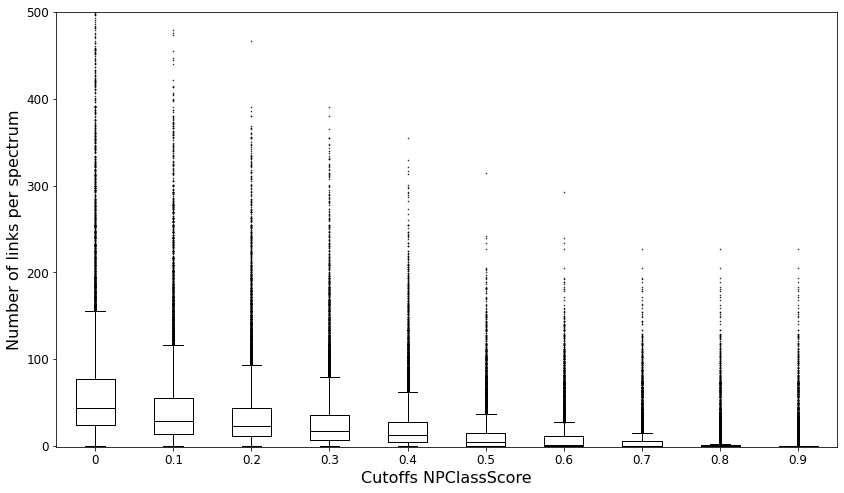

In [124]:
sorted_filt_items_spec = sorted(d_all_num_filtered_links_spec.items())
labels_spec = ["0"] + [f"{cut:.1f}" for cut, vals in sorted_filt_items_spec]
xs_spec = [d_all_num_links_spec] + [vals for keys, vals in sorted_filt_items_spec]
lg_size = 14
custom_xlim = (-1, 500)
links_title_spec = "Number of links per spectrum"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs_spec, labels=labels_spec, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title_spec)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_npclass_spectra_mix_can-mne_figure.svg"
plt.savefig(figout)

In [125]:
npcl_spec = npl.scoring_method('npclassscore')
npcl_spec.cutoff = 0.4
results_both_spec = npl.get_links(npl.spectra, [mc, npcl_spec], and_mode=True)

print('Number of results: {}'.format(len(results_both_spec)))

19:19:25 [INFO] methods.py:982, Running NPClassScore...
19:19:25 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
19:20:24 [INFO] methods.py:1003, Calculating NPClassScore for 13667 objects to 1581 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
19:23:58 [WARNING] methods.py:1047, 1545 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
19:23:58 [INFO] methods.py:1052, NPClassScore completed in 273.1s
Number of results: 12880


For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.4.

In [126]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links_spec = []
all_num_filtered_links_spec = []
all_no_scores_spec = []

for spec in npl.spectra:
    num_links = 0
    if spec in results_spec.links:
        num_links = len([link_data for link_data in results_spec.get_sorted_links(mc, spec)])

    num_filtered_links = 0
    if spec in results_both_spec.links:
        num_filtered_links = len([link_data for link_data in results_both_spec.get_sorted_links(mc, spec)])
    all_num_links_spec.append(num_links)
    all_num_filtered_links_spec.append(num_filtered_links)

np.mean(all_num_links_spec), np.mean(all_num_filtered_links_spec)

(64.69371478744421, 27.860832662617984)

Use MNE when there is no CANOPUS prediction


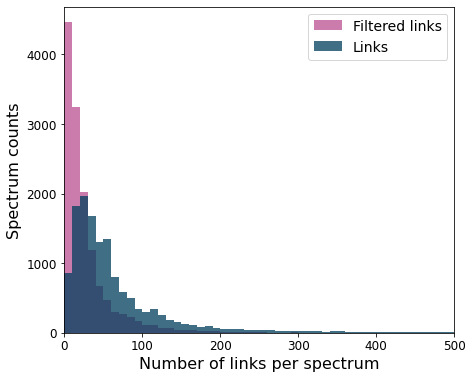

In [127]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links_spec, all_num_filtered_links_spec]
lg_size = 14
custom_xlim = (-1, 500)
bin_size = 10
n_bins = np.arange(0, 2500, bin_size)
links_title = "Number of links per spectrum"
count_title = "Spectrum counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_spectra_mix_can-mne_figure_new.svg"
plt.savefig(figout)